In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from scipy.optimize import root
import h5py
import os
import itertools

n_boot = 200
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from pytools import *
from formattools import *
from plottools import *

# Plot data

In [2]:
l, t = 12, 24
file = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_106539.h5'

Lat = Lattice(l, t)
f = h5py.File(file, 'r')
print('Ran on ' + str(f['cfgnum'][()]) + ' cfgs.')
k_list = f['momenta'][()]
Zq = f['Zq'][()]
Zqq3 = f['Zqq3'][()]
Zqq6 = f['Zqq6'][()]
Zqq_mix = f['Zqq_mix'][()]
f.close()

Ran on 122 cfgs.


In [3]:
h = lambda p : np.sum(p ** 4) / (square(p) ** 2)
kidx = 0
k_subset_idxs = []
for k in k_list:
    # if True:
    # if k[0] < 5 and k[1] < 5 and k[2] < 5 and k[3] < 5:
    if k[0] < Lat.L // 2 and k[1] < Lat.L // 2 and k[2] < Lat.L // 2 and k[3] < Lat.L // 2:
        k_subset_idxs.append(kidx)
    kidx += 1
k_subset_idxs = np.array(k_subset_idxs)

# only use k if it's less than L / 2 in each component
# k_list = k_list[k_subset_idxs]
p_list = np.array([Lat.to_linear_momentum(k) for k in k_list])
plat_list = np.array([Lat.to_lattice_momentum(k) for k in k_list])
apsq_list = np.real(np.array([square(p) for p in p_list]))

k_list_sub = k_list[k_subset_idxs]
p_list_sub = p_list[k_subset_idxs]
plat_list_sub = plat_list[k_subset_idxs]
apsq_list_sub = apsq_list[k_subset_idxs]

Zq = np.real(Zq)
Zqq3_sub = np.einsum('ktz->tkz', np.real(Zqq3[k_subset_idxs]))
Zqq6_sub = np.einsum('ktz->tkz', np.real(Zqq6[k_subset_idxs]))
Zqq3 = np.einsum('ktz->tkz', np.real(Zqq3))
Zqq6 = np.einsum('ktz->tkz', np.real(Zqq6))

In [4]:
Zq_mu = np.mean(Zq, axis = 1)
Zq_sigma = np.std(Zq, axis = 1, ddof = 1)
Zqq3_mu = np.mean(Zqq3_sub, axis = 2)    # compute Zqq on subsets
Zqq3_sigma = np.std(Zqq3_sub, axis = 2, ddof = 1)
Zqq6_mu = np.mean(Zqq6_sub, axis = 2)
Zqq6_sigma = np.std(Zqq6_sub, axis = 2, ddof = 1)

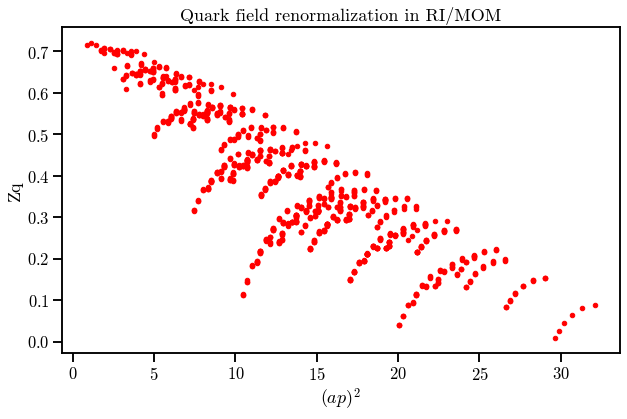

In [5]:
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    plt.errorbar(apsq_list, Zq_mu, Zq_sigma, fmt = '.', c = 'r')
    plt.xlabel('$(ap)^2$')
    plt.ylabel('Zq')
    plt.title('Quark field renormalization in RI/MOM')
    plt.show()

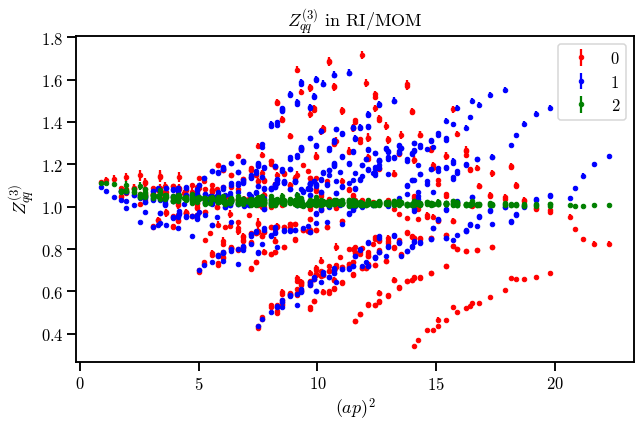

In [6]:
colors3 = ['r', 'b', 'g']
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for t in range(3):
        plt.errorbar(apsq_list_sub, Zqq3_mu[t], Zqq3_sigma[t], fmt = '.', c = colors3[t], label = str(t))
    plt.xlabel('$(ap)^2$')
    plt.ylabel('$Z_{qq}^{(3)}$')
    plt.title('$Z_{qq}^{(3)}$ in RI/MOM')
    plt.legend()
    plt.show()

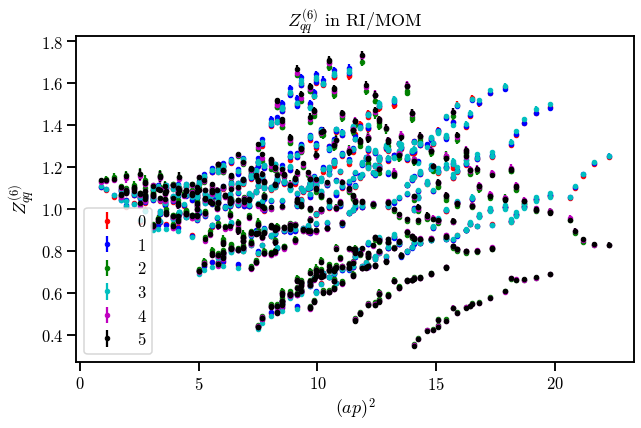

In [7]:
colors6 = ['r', 'b', 'g', 'c', 'm', 'k']
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for t in range(6):
        plt.errorbar(apsq_list_sub, Zqq6_mu[t], Zqq6_sigma[t], fmt = '.', c = colors6[t], label = str(t))
    plt.xlabel('$(ap)^2$')
    plt.ylabel('$Z_{qq}^{(6)}$')
    plt.title('$Z_{qq}^{(6)}$ in RI/MOM')
    plt.legend()
    plt.show()

## Plot each RC with the amount of h(p)

In [8]:
h = lambda p : np.sum(p ** 4) / (square(p) ** 2)
hp_list = np.real(np.array([h(p) for p in p_list]))
hp_list_sub = hp_list[k_subset_idxs]
# cols = ['m', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:brown', 'k']
cols = ['k', 'tab:brown', 'b', 'g', 'y', 'tab:orange', 'r', 'm']
cuts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def color_fn(hp):
    for ii in range(len(cols)):
        if hp < cuts[ii]:
            return cols[ii]
    return cols[-1]
color_list = [color_fn(hp) for hp in hp_list]
color_list_sub = [color_fn(hp) for hp in hp_list_sub]
patches = [mpatches.Patch(color = cols[ii], label = '$h(p) < ' + str(cuts[ii]) + '$') for ii in range(len(cols))]

In [9]:
def plot_h4_breaking(Zmu, Zsigma, label, plt_geom = (1, 1), fsize = (10, 6), leg_loc = (1., 1.)):
    with sns.plotting_context('talk'):
        if plt_geom == (1, 1):
            plt.figure(figsize = (10, 6))
            for ii in range(len(apsq_list)):
                plt.errorbar(apsq_list[ii], Zmu[ii], Zsigma[ii], fmt = '.', c = color_list[ii])
            plt.xlabel('$(ap)^2$')
            #plt.xlim((0, 7))
            plt.ylabel(label)
            plt.title(label + ' in RI/MOM')
            plt.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.show()
        else:
            fig, ax = plt.subplots(plt_geom[0], plt_geom[1], figsize = fsize)
            for i in range(plt_geom[0]):
                for j in range(plt_geom[1]):
                    tidx = j * plt_geom[0] + i
                    if tidx >= Zmu.shape[0]:
                        continue
                    for pidx in range(len(apsq_list_sub)):
                        ax[i, j].errorbar(apsq_list_sub[pidx], Zmu[tidx, pidx], Zsigma[tidx, pidx], fmt = '.', \
                                          c = color_list[pidx])
                    ax[i, j].set_xlabel('$(ap)^2$')
                    ax[i, j].set_ylabel(label)
                    #ax[i, j].set_xlim((0, 7))
                    ax[i, j].set_title(label + ', comp ' + str(tidx) + ' in RI/MOM')
            fig.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.tight_layout()
            plt.show()

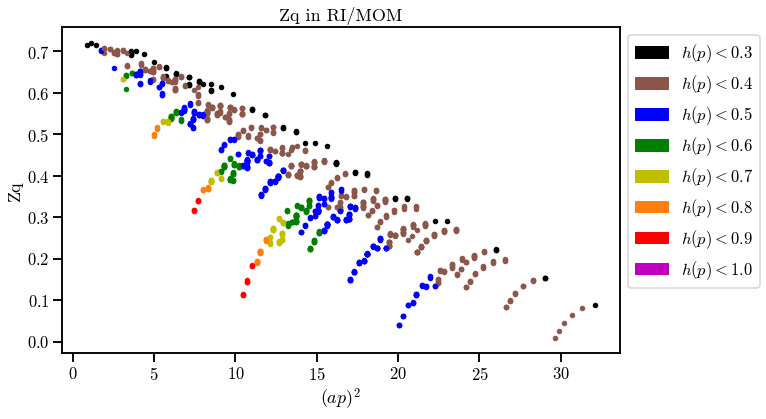

In [10]:
plot_h4_breaking(Zq_mu, Zq_sigma, 'Zq')

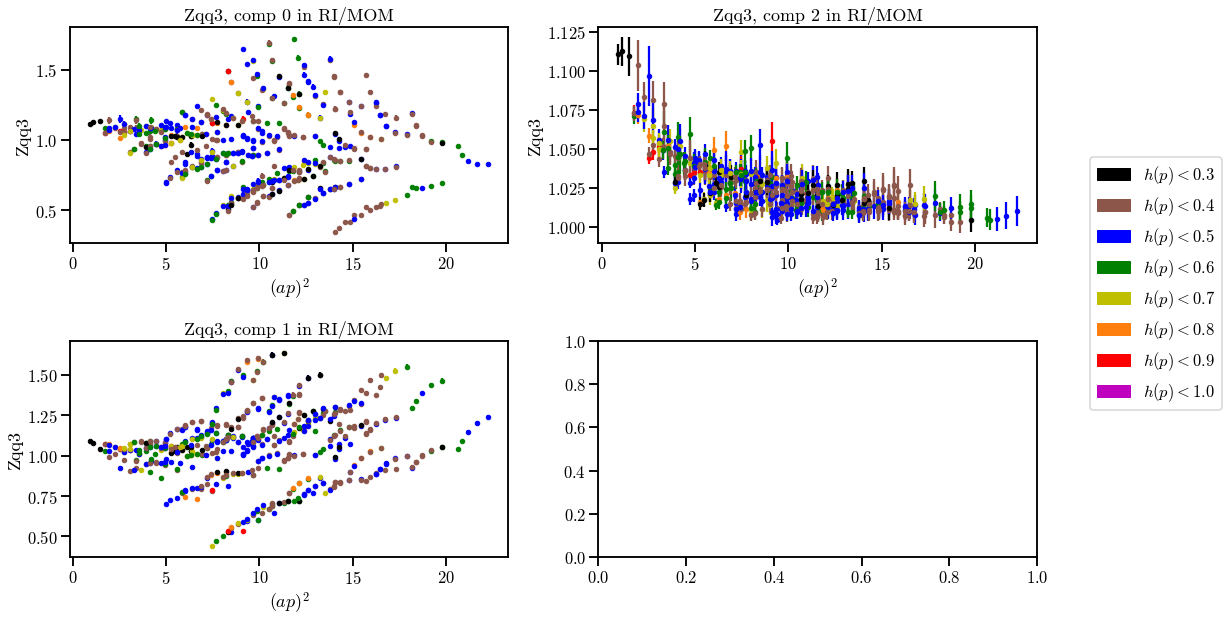

In [11]:
plot_h4_breaking(Zqq3_mu, Zqq3_sigma, 'Zqq3', plt_geom = (2, 2), fsize = (15, 9), leg_loc = (1.15, 0.75))

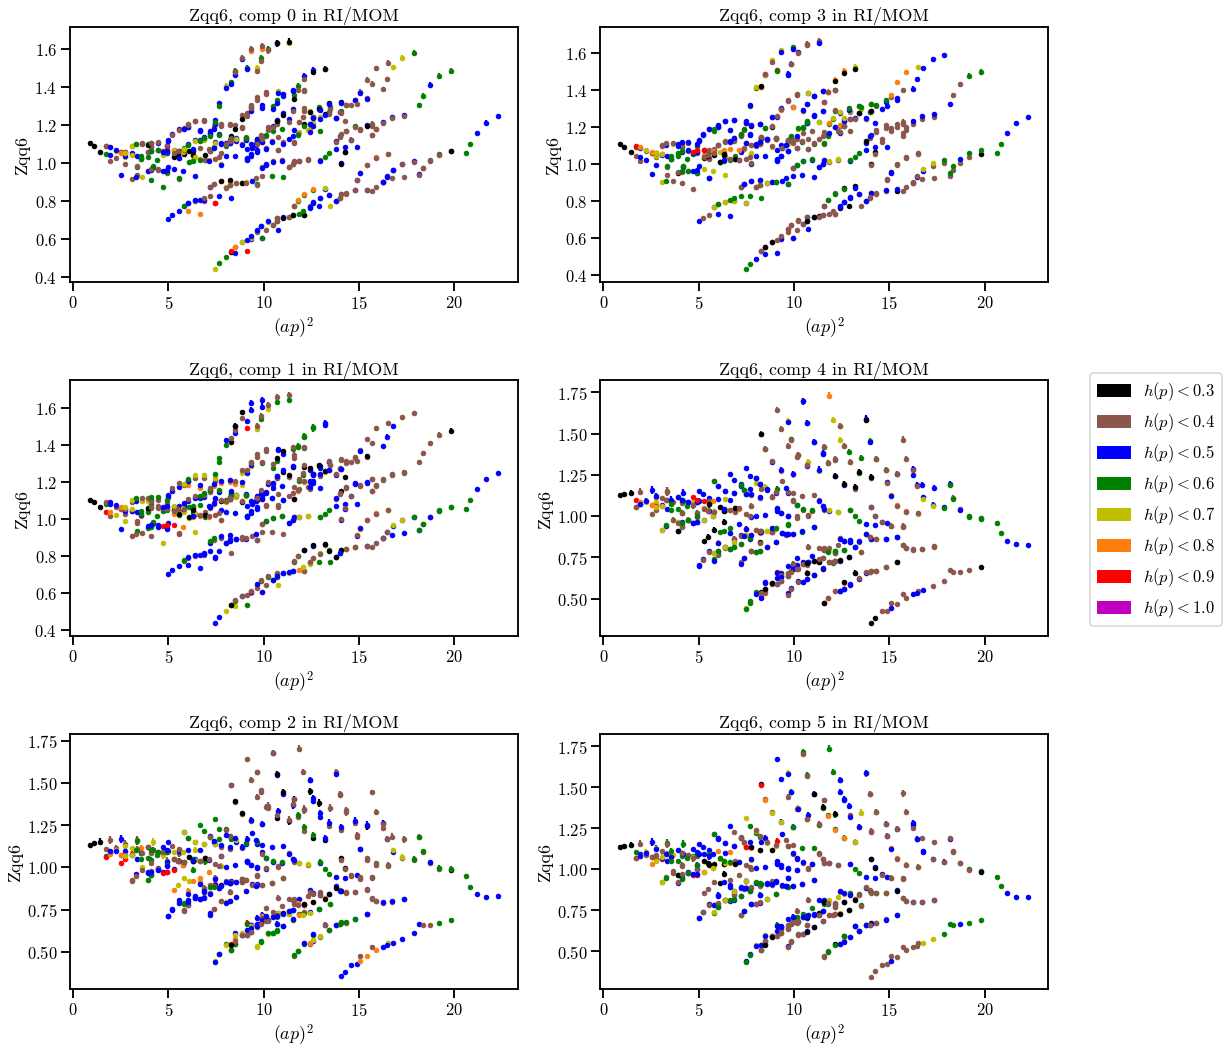

In [12]:
plot_h4_breaking(Zqq6_mu, Zqq6_sigma, 'Zqq6', plt_geom = (3, 2), fsize = (15, 15), leg_loc = (1.15, 0.65))

In [13]:
Zqq_mix_mu = np.mean(np.real(Zqq_mix), axis = 2)
Zqq_mix_sigma = np.std(np.real(Zqq_mix), axis = 2, ddof = 1)

$a = 0.1167\;\mathrm{fm}$

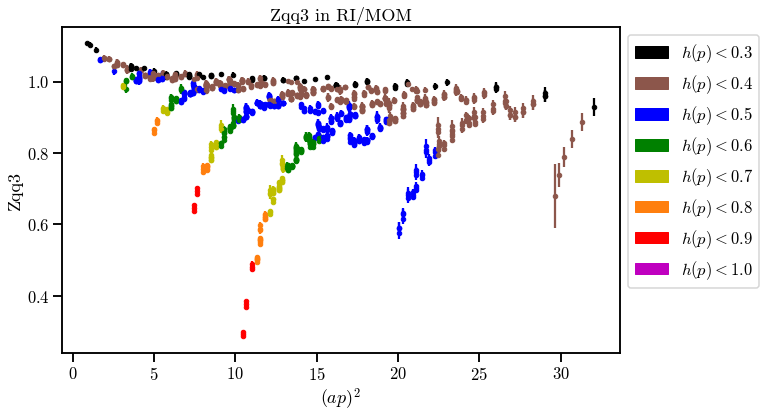

In [14]:
plot_h4_breaking(Zqq_mix_mu[0], Zqq_mix_sigma[0], 'Zqq3')

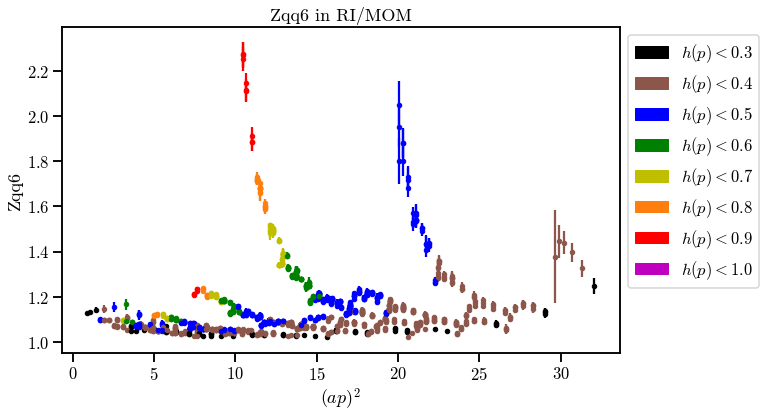

In [17]:
plot_h4_breaking(Zqq_mix_mu[1], Zqq_mix_sigma[1], 'Zqq6')

In [16]:
# Will mentioned it would be a good idea to put this in a Pandas dataframe

# Convert to $\overline{\mathrm{MS}}$

# Fit data